In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

from sklearn.neighbors.kde import KernelDensity
from sklearn.neighbors import DistanceMetric

import sys
sys.path.insert(0, 'src/')
from create_dataset import *

%matplotlib inline

## Dataset Loading

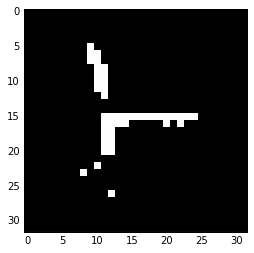

In [11]:
t = 0.01

def load_flatten_images(paths):
    images = []
    for p in paths:
        img = mpimg.imread(p).flatten()
        img[img > t] = 1.0
        img[img < t] = 0.0
        images.append(img.astype(int))
    return np.array(images)

def load_flatten_voxels(paths, t=0.1):
    voxels = []
    for p in paths:
        vox = np.load(p).flatten()
        vox[vox > t] = 1.0
        vox[vox < t] = 0.0
        voxels.append(vox.astype(int))
    return np.array(voxels)

def load_voxels(paths):
    voxels = []
    for p in paths:
        vox = np.load(p)
        vox[vox > t] = 1.0
        vox[vox < t] = 0.0
        voxels.append(vox.astype(int))
    return np.array(voxels)

#Images
data_images = load_flatten_images(glob.glob("data/chairs_blur/*.png"))
prgan_images = load_flatten_images(glob.glob("results/PrGANchairs_blur/image*.png"))
gan2d_images = load_flatten_images(glob.glob("results/ImageGANchairs_blur/image*.png"))

#Volumes
data_voxels = load_flatten_voxels(glob.glob("data/chairs_voxel/*.npy"))
prgan_voxels = load_voxels(glob.glob("results/PrGANchairs_blur/*.npy"))
gan3d_voxels = load_flatten_voxels(glob.glob("results/VoxelGANchairs_voxel/*.npy"))

plt.imshow(np.reshape(data_images[1],(32,32)), interpolation='none', cmap='gray')
plt.imshow(np.reshape(gan2d_images[5],(32,32)), interpolation='none', cmap='gray')

In [ ]:
test_volume = np.reshape(prgan_voxels[0], (32,32,32))


#### Computes data distance matrix

In [9]:
def median_distance(data):
    dist = DistanceMetric.get_metric('hamming')
    dist_matrix = dist.pairwise(data)
    dm = np.eye(dist_matrix.shape[0])*1000 + dist_matrix
    return np.median(np.min(dm, axis=0))

In [12]:
print median_distance(data_images[0:10, :])
print median_distance(data_images[0:50, :])
print median_distance(data_images[0:100, :])
print median_distance(data_images)

0.140234375
0.11052734375
0.089599609375
0.0147512530413


## Kernel Density Estimation

ImageGAN:  4037.55620661
PrGAN:  4384.03616285
VoxelGAN:  195225.562543
PrGAN:  195760.269905


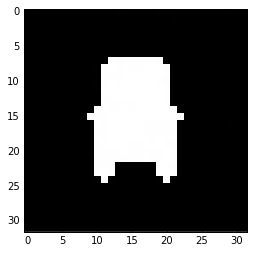

In [56]:
bw = np.median(np.min(dm, axis=0))
kde_2d = KernelDensity(kernel='gaussian', metric='hamming', bandwidth=bw).fit(data_images)
plt.imshow(np.reshape(kde.sample(),(32,32)), interpolation='none', cmap='gray')
gan2d_ll = np.mean(kde.score_samples(gan2d_images))
prgan_ll = np.mean(kde.score_samples(prgan_images))
print "ImageGAN: ", gan2d_ll
print "PrGAN: ", prgan_ll

bw3d = np.median(np.min(dm, axis=0))
kde_voxels = KernelDensity(kernel='gaussian', metric='hamming', bandwidth=bw3d).fit(data_voxels)
gan3d_ll = np.mean(kde_voxels.score_samples(gan3d_voxels))
prgan3d_ll = np.mean(kde_voxels.score_samples(prgan_voxels))
print "VoxelGAN: ", gan3d_ll
print "PrGAN: ", prgan3d_ll

In [4]:
def mmd (x, y, bw):
    kde_data = KernelDensity(kernel='gaussian', metric='hamming', bandwidth=bw).fit(x)
    kde_sample = KernelDensity(kernel='gaussian', metric='hamming', bandwidth=bw).fit(y)
    
    xx = np.mean(kde_data.score_samples(x))
    yy = np.mean(kde_sample.score_samples(y))
    xy = np.mean(kde_data.score_samples(y))
    
    return np.power(xx - xy + yy, 0.5)

def mmd_voxels_synth(x, y, bw):
    kde_data = KernelDensity(kernel='gaussian', metric='hamming', bandwidth=bw).fit(x)
    vy = y.copy().reshape((y.shape[0], y.shape[1]**3))
    xx = np.mean(kde_data.score_samples(x))
    dists = []
    for theta in np.linspace(0, 2*np.pi, 8, endpoint=False):
        for v in range(vy.shape[0]):
            vy[v,:] = transform_volume(y[v,:,:,:], theta).flatten()
        kde_sample = KernelDensity(kernel='gaussian', metric='hamming', bandwidth=0.001).fit(vy)
        yy = np.mean(kde_sample.score_samples(vy))
        xy = np.mean(kde_data.score_samples(vy))
        dists.append(np.power(xx - xy + yy, 0.5))
    return np.amin(np.array(dists))
        

print mmd(data_images, gan2d_images, 0.001)
print mmd(data_images, prgan_images, 0.001)

90.1269040761
88.3092782081


In [12]:
print mmd(data_voxels, gan3d_voxels, 0.01)
print mmd_voxels_synth(data_voxels, prgan_voxels[0:64,:,:,:], 0.01)

347.547338092
442.985320022


In [13]:
print gan3d_voxels.shape

(64, 32768)


In [17]:
prgan_1v = load_voxels(glob.glob("results/PrGANchairs_1view/*.npy"))
prgan_2v = load_voxels(glob.glob("results/PrGANchairs_2view/*.npy"))
prgan_4v = load_voxels(glob.glob("results/PrGANchairs_4view/*.npy"))

print mmd_voxels_synth(data_voxels, prgan_1v[0:64,:,:,:], 0.01)
print mmd_voxels_synth(data_voxels, prgan_2v[0:64,:,:,:], 0.01)
print mmd_voxels_synth(data_voxels, prgan_4v[0:64,:,:,:], 0.01)

442.988800166
442.984726061
442.9878173
